# Testing stochastic gradient descent method.
2017-09-27

How would you solve the likelihood maximization problem as detailed in Lee (2018). This code is a test by comparing with the exact answer.

All the preamble must be run for this to work, and this is hard-coded for a system of size 5. All the implementation is in *Tester*. Some comparisons with the exact solution that is solved on the observables calculated from the incomplete data are shown at the end.

When we have data where some of the spins $s'$ are missing (or hidden), one model could be that we've sampled from the full joint distribution of all spins $S$, but now we've hidden spins $s'$. Since the probability of the configuration of the full distribution is $p(S) = p(s'|s)p(s)$, we can maximize the likelihood given the model since $p(s) = \sum_{s'}p(S)$.

Instead of a full derivation starting with maximizing entropy with these constraints, we imagine that the incomplete data is a marginalization of the model. Then, maximum likelihood in this case leads to finding the root of the equation $\langle\langle f_k\rangle_{\rm subset}\rangle_{\rm data}-<f_k>_{\rm data}$.

The simple iterative algorithm proposed in Broderick et al. doesn't work here because you aren't guaranteed that increasing the parameters necessarily corresponds to pushing the error in one direction or another because $<<f_k>_{\rm subset}>_{\rm data}$ depends on the model. This landscape is also degenerate (think of these as nonlinear constraints when maximizing entropy).

The solution is to just minimize the sum of squares $\epsilon = \sum_k (<<f_k>>-<f_k>)^2$.

In [1]:
# Setup iPython environment.
%pylab inline
plt.rc('font',size=20)

%load_ext autoreload
%autoreload 2

Populating the interactive namespace from numpy and matplotlib
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
# Import common libraries.
from __future__ import division
from solvers import *
from utils import *
from test import *
import ising_eqn_5_sym
from scipy.optimize import minimize

# Define common functions.
calc_e,calc_observables,mchApproximation = define_ising_helpers_functions()

# Generate example data set.
n = 5  # system size
np.random.seed(0)
h,J = np.random.normal(scale=.1,size=n),np.random.normal(scale=.1,size=n*(n-1)//2)  # random fields, couplings
hJ = np.concatenate((h,J))
p = ising_eqn_5_sym.p(hJ)  # probability distribution of all states p(s)
sisjTrue = ising_eqn_5_sym.calc_observables(hJ)  # exact magnetizations and pairwise correlations

ALL_STATES = bin_states(n,True)  # all 2^n possible binary states in {-1,1} basis

# Mask some of the data points. These are the "incomplete" data points.
sample = ALL_STATES[random.choice(range(2**n),size=10,replace=True,p=p)]  # random sample from p(s)

maskedSample = sample.copy()
for i in xrange(5):
    maskedSample[i*4:(i+1)*4,i:i+2] = 0

# Calculate sisj only from the available data points between pairs of spins.
sisj = pair_corr(maskedSample,exclude_empty=True,concat=True)

assert (maskedSample==0).any(1).all()

## Checking gradient calculation.
By comparing analytic and MCH methods.

In [475]:
testermch = TesterMCH(maskedSample,hJ.copy())
tester = Tester(maskedSample,hJ.copy())

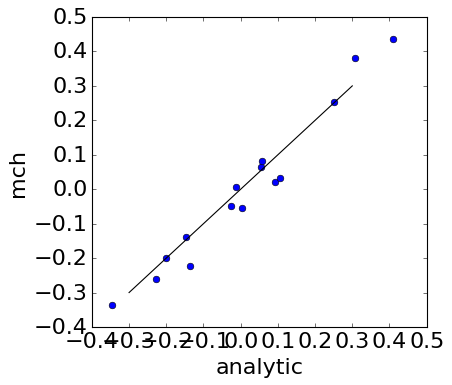

In [476]:
# Error comes from the fact that p is approximation in MCH.
fig,ax = plt.subplots(figsize=(5.4,5))
ax.plot( tester.perturb(0,0)[0],testermch.perturb(0,0)[0],'o' )
ax.plot([-.3,.3],[-.3,.3],'k-')
ax.set(xlabel='analytic',ylabel='mch')

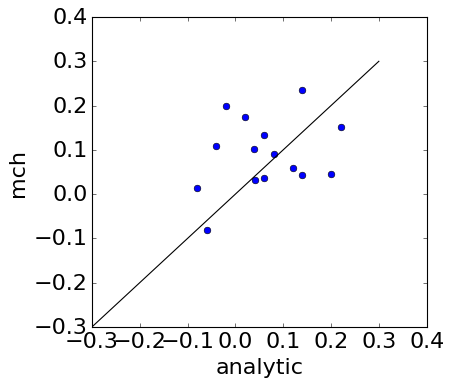

In [480]:
eps = 1e-3

fig,ax = plt.subplots(figsize=(5.4,5))
ax.plot( testermch.perturb(eps,0)[1],tester.perturb(eps,0)[1],'o' )
ax.plot([-.3,.3],[-.3,.3],'k-')
ax.set(xlabel='analytic',ylabel='mch')

Checking gradient. This checks out well if we average over several MCH approximations to the gradient.

In [493]:
niters = 5
mchgradList = zeros((niters,len(hJ)))
for i in xrange(niters):
    mchgradList[i] = testermch.calc_grad(1e-5)
mchgradList = vstack(mchgradList)

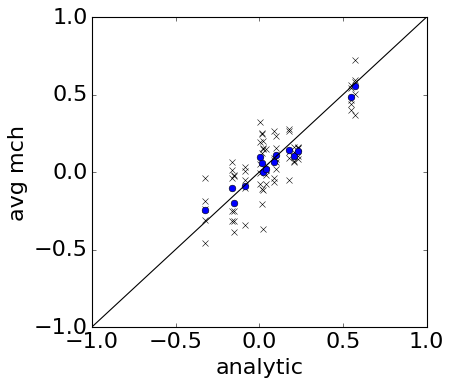

In [498]:
fig,ax = plt.subplots(figsize=(5.4,5))
for grad in mchgradList:
    ax.plot(tester.calc_grad(1e-5),grad,'kx')
ax.plot(tester.calc_grad(1e-5),mchgradList.mean(0),'bo',ms=6)
ax.plot([-1,1],[-1,1],'k-')
ax.set(xlabel='analytic',ylabel='avg mch')

## Solving for parameters.

In [219]:
from entropy import *
from itertools import combinations

In [502]:
# Are the triplet probability distributions consistent? No!
for i,j,k in combinations(range(5),3):
    if did_all_pairs_vote(maskedSample,i,j,k):
        print check_triplet(maskedSample[:,[i,j,k]])

False
False
False


In [182]:
# Exact solution.
def calc_observables_multipliers(J):
    """
    Calculate observables from probability distribution given Langrangian multipliers.
    """
    E = calc_e(ALL_STATES,J)
    return pair_corr( ALL_STATES, np.exp(-E-logsumexp(-E)),concat=True )

# Declare and call solver.
solver = Exact(n,
               calc_observables_multipliers=calc_observables_multipliers,
               calc_observables=calc_observables)
exactsoln,soln = solver.solve(constraints=sisj)

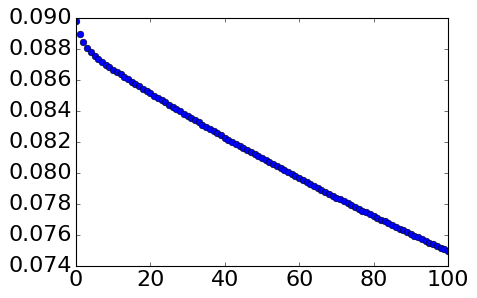

In [274]:
# Gradient descent analytically. This needs to be manually iterated several times.
errorHistory = []
eps = 5e-2  # change this to take bigger steps

# tester = Tester(maskedSample,hJ.copy())
# tester = Tester(maskedSample,exactsoln.copy())
tester = Tester(maskedSample,tester.lamda.copy())
errorHistory.append( tester.error() )

for i in xrange(100):
    # Take a step down the gradient.
    grad = tester.calc_grad()

    tester.lamda -= grad*eps
    if len(errorHistory)>1:
        if errorHistory[i]>errorHistory[i-1]:
            tester.lamda += grad*eps
            errorHistory.pop()
            break
    errorHistory.append( tester.error() )

plt.plot(errorHistory,'o')

# Degeneracy of solutions.
Depending on the method used to find the minimum, it seems that we can find many different minima.

In [ ]:
# Using scipy.optimize.minimize.
def f(params):
    tester.lamda = params
    return tester.error(),tester.calc_grad()

# Try a bunch of random starting locations to see if we get many answers.
solns = []
for i in xrange(10):
    solns.append( minimize(f,random.normal(scale=.1,size=len(hJ))+exactsoln,jac=True) )

In [360]:
for s in solns:
    print s['fun'],s['status']

0.000633564829188 2
0.000890785312477 2
0.00094414376818 2
0.000811343312032 2
0.000500180312865 2
0.000704193646717 2
0.00116071412541 2
0.00060915734367 2
0.000654390730419 2
0.00120582827438 2


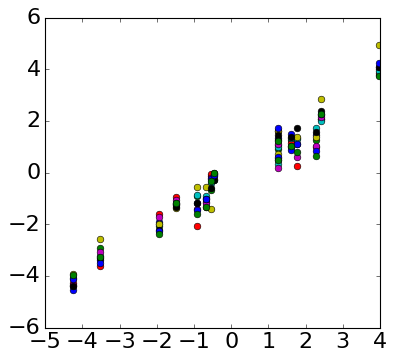

In [363]:
fig,ax = plt.subplots(figsize=(5.4,5))
for s in solns[1:]:
    ax.plot(solns[0]['x'],s['x'],'o')

In [412]:
# Testing use of gradient.
def f(params):
    tester.lamda = params
    return tester.error()
def fgrad(params):
    tester.lamda = params
    return tester.calc_grad(eps=1e-8)

# Try a bunch of random starting locations to see if we get many answers.
solns = []
solns.append( minimize(f,exactsoln) )
solns.append( minimize(f,exactsoln,jac=fgrad) )
solns.append( minimize(f,exactsoln,jac=fgrad,method='CG') )

In [435]:
[norm(s['jac']) for s in solns]

[0.39484660792302007, 4.7756523945308438e-06, 1.1078160179214735e-05]

In [436]:
[s['fun'] for s in solns]

[9.051117710825948e-05, 1.4614091772382111e-06, 7.595576585477162e-06]

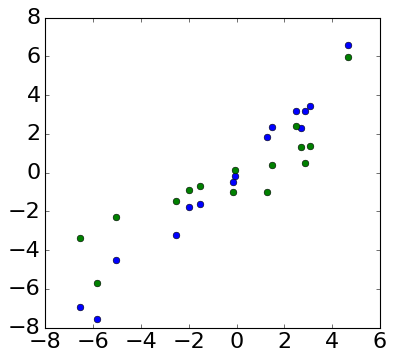

In [438]:
# The parameters are quite different from one another.
fig,ax = plt.subplots(figsize=(5.4,5))
for s in solns[1:]:
    ax.plot(solns[0]['x'],s['x'],'o')

In [426]:
from scipy.spatial.distance import pdist

In [441]:
p = vstack([ising_eqn_5_sym.p(s['x']) for s in solns] )

In [442]:
pdist(p)

array([ 0.004 ,  0.0107,  0.007 ])

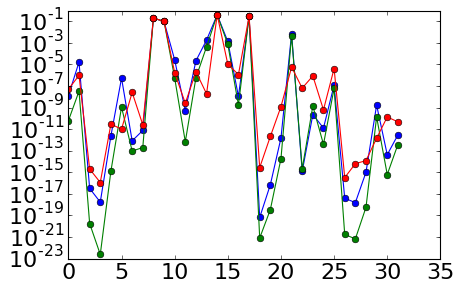

In [443]:
fig,ax = plt.subplots()
for row in p:
    ax.semilogy(row,'o-')

In [454]:
# Check that the Hessian is positive definite at all solutions. This should be the case without fail...
# It's not always positive, but reassuringly negative curvature is very small.
from numdifftools import Hessian
hessApproxFun = Hessian(f)
hess = [hessApproxFun(s['x']) for s in solns] 

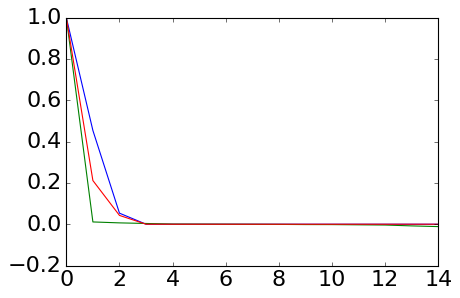

In [474]:
# Hessian has negative eigenvalues, but they're very small.
fig,ax = plt.subplots()
for h in hess:
    L = sort(linalg.eig(h)[0])[::-1]
    L /= L[0]
    ax.plot( L )

In [419]:
# Is this supposed to be a large error? 1e-6 seems pretty small to affect the answer very much.
from scipy.optimize import check_grad
def fgrad(params):
    tester.lamda = params
    return tester.calc_grad(eps=1e-8)
check_grad(f,fgrad, exactsoln)

7.3553094470328736e-08

In [293]:
from misc.plot import colorcycle

[(-1, 1), (-1, 1)]

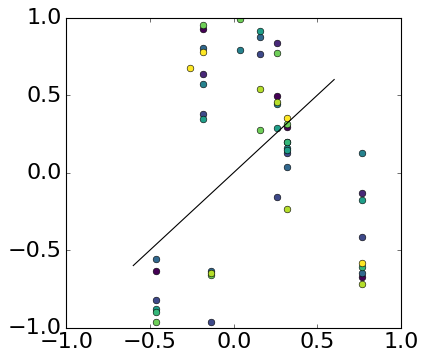

In [294]:
# Compare analytic with MCH
cc = colorcycle(len(solns))
fig,ax = plt.subplots(figsize=(5.4,5))
for s in solns:
    ax.plot(testermch.lamda,s['x'],'o',c=cc.next())
ax.plot([-.6,.6],[-.6,.6],'k-')
ax.set(xlim=[-1,1],ylim=[-1,1])

In [313]:
# Gradient descent using MCH.
# testermch = TesterMCH(maskedSample,hJ.copy())
testermch = TesterMCH(maskedSample,testermch.lamda.copy())

# Pure gradient descent.
# errorHistory = descend_gradient(testermch,n_iter=20,eps=.5e-1)
# plt.plot(errorHistory,'o')

# Using BFGS
def f(params):
    testermch.lamda = params
    return testermch.error(),testermch.calc_grad()

# Try a bunch of random starting locations to see if we get many answers.
soln = minimize(f,random.normal(scale=.1,size=len(hJ))+testermch.lamda,
                method='BFGS',jac=True,options={'maxiter':10})

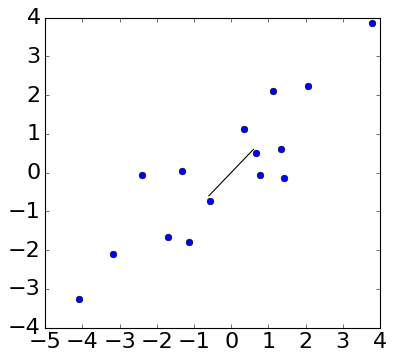

In [316]:
# Compare analytic with MCH
fig,ax = plt.subplots(figsize=(5.4,5))
ax.plot(tester.lamda,testermch.lamda,'o')
ax.plot([-.6,.6],[-.6,.6],'k-')

In [310]:
# Value of the objective being minimized by the gradient method.
p = ising_eqn_5_sym.p(exactsoln)
print norm( tester.fk_maxent(p)-tester.fk_data(p) )

p = ising_eqn_5_sym.p(tester.lamda)
print norm( tester.fk_maxent(p)-tester.fk_data(p) )

p = ising_eqn_5_sym.p(testermch.lamda)
print norm( tester.fk_maxent(p)-tester.fk_data(p) )

0.556149147255
0.00606958847204
0.961256968567


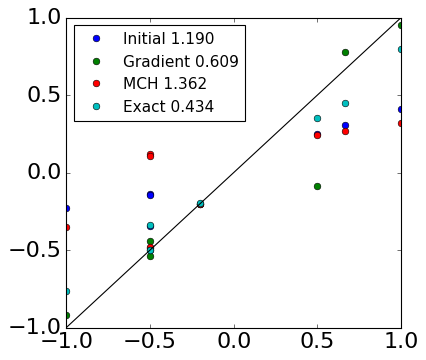

In [253]:
# Comparison of solutions.
p = ising_eqn_5_sym.p(hJ)
initialsisj = tester.fk_data(p)

p = ising_eqn_5_sym.p(tester.lamda)
solnsisj = tester.fk_data(p)

p = ising_eqn_5_sym.p(testermch.lamda)
mchsisj = tester.fk_data(p)

p = ising_eqn_5_sym.p(exactsoln)
exactsisj = tester.fk_maxent(p)

fig,ax = plt.subplots(figsize=(5.4,5))
nonzeroix = sisj!=0
ax.plot(sisj[nonzeroix],initialsisj[nonzeroix],'o')
ax.plot(sisj[nonzeroix],solnsisj[nonzeroix],'o')
ax.plot(sisj[nonzeroix],mchsisj[nonzeroix],'o')
ax.plot(sisj[nonzeroix],exactsisj[nonzeroix],'o')
ax.plot([-1,1],[-1,1],'k-')

ax.legend(('Initial %1.3f'%norm((initialsisj-sisj)[nonzeroix]),
           'Gradient %1.3f'%norm((solnsisj-sisj)[nonzeroix]),
           'MCH %1.3f'%norm((mchsisj-sisj)[nonzeroix]),
           'Exact %1.3f'%norm((exactsisj-sisj)[nonzeroix])),
           numpoints=1,loc=0,fontsize='x-small')

In [244]:
print "The exact soln matches the given pairwise correlations exactly,"
print 'Model: %1.3f\t Exact: %1.3f'%(norm(solnsisj-sisj),norm(exactsisj-sisj))

# but does not do well with the objective given to gradient descent
p = ising_eqn_5_sym.p(tester.lamda)
modelerr = norm( tester.fk_maxent(p)-tester.fk_data(p) )

p = ising_eqn_5_sym.p(exactsoln)
exacterr = norm( tester.fk_maxent(p)-tester.fk_data(p) )
print 'Model: %1.3f\t Exact: %1.3f'%(modelerr,exacterr)

# Which also corresponds to a difference in the likelihood of the data given this marginalization
# model of data samples
print 'Model: %1.3f\t Exact: %1.3f'%(conditional_likelihood(maskedSample,tester.lamda),
                                     conditional_likelihood(maskedSample,exactsoln))

print ""
print "There's not much improvement from using this algorithm in the likelihood, but you can see below that the parameters change a fair amount."

The exact soln matches the given pairwise correlations exactly,
Model: 1.921	 Exact: 0.547
Model: 0.063	 Exact: 0.556
Model: -15.487	 Exact: -15.320

There's not much improvement from using this algorithm in the likelihood, but you can see below that the parameters change a fair amount.


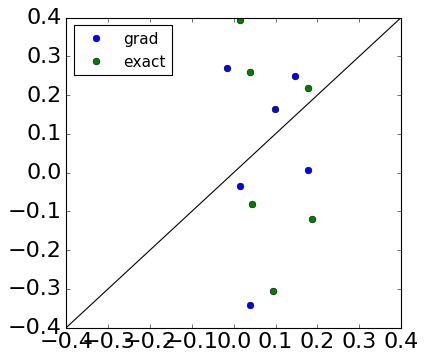

In [238]:
# Comparison of the parameters between true and gradient descent.
# Parameters don't change much, but they're clearly not the same.
# Is it worth it taking this incomplete nature of the data into account?
mx = abs(concatenate((hJ,tester.lamda))).max()
fig,ax = plt.subplots(figsize=(5.4,5))
ax.plot(hJ,tester.lamda,'o')

# Comparison of the parameters between true and exact.
mx = abs(concatenate((hJ,exactsoln))).max()
ax.plot(hJ,exactsoln,'o')
ax.plot([-.4,.4],[-.4,.4],'k-')
ax.set(xlim=[-.4,.4],ylim=[-.4,.4])
ax.legend(('grad','exact'),numpoints=1,fontsize='x-small',loc=0)